@auther: boya

This notebook will guide you step by step build a RNN based on pytorch which can detect digits from images.


### Import Header


In [1]:
import os
from typing import Dict, List
from pathlib import Path
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import h5py
import time
import numpy as np
import random
import imgaug.augmenters as iaa
from tqdm import tqdm

device = "cuda"
dtype = torch.float64
height = 224
width = 224

### Help Function

This function is for collecting all digits as label from the raw dataset.


In [2]:
def _get_digits(bboxes, h5_file):
    tstart = time.time()

    def key_to_values(key, bbox):
        if bbox[key].shape[0] == 1:
            return [int(bbox[key][0][0])]
        else:
            return [int(h5_file[bbox[key][i][0]][()].item()) for i in range(bbox[key].shape[0])]

    bbox = h5_file[bboxes[0]]
    assert bbox.keys() == {"height", "left", "top", "width", "label"}
    labels = key_to_values("label", bbox)
    print(time.time()-tstart)
    return [label % 10 for label in labels]

### Load dataset and preview


0.000659942626953125
0.0005371570587158203
0.0005614757537841797
0.0005202293395996094
0.0005173683166503906
0.0005223751068115234
0.0005049705505371094
0.0006616115570068359
0.0006606578826904297
0.0005064010620117188
0.00048661231994628906
0.00047206878662109375
0.0004999637603759766
0.00045871734619140625
0.0004649162292480469
0.00045871734619140625
0.0004870891571044922
0.0004742145538330078
0.0006322860717773438
0.0005004405975341797
0.00017213821411132812
0.0006198883056640625
0.0004904270172119141
0.0004794597625732422
0.0006325244903564453
0.000453948974609375
0.00045371055603027344
0.0004839897155761719
0.0006566047668457031
0.000453948974609375
0.0005998611450195312
0.00044536590576171875
0.00045609474182128906
0.00045680999755859375
0.00016760826110839844
0.0004591941833496094
0.0004742145538330078
0.00046634674072265625
0.0004487037658691406
0.0004611015319824219
0.0004506111145019531
0.0006167888641357422
0.00045990943908691406
0.0006389617919921875
0.0004475116729736328
0

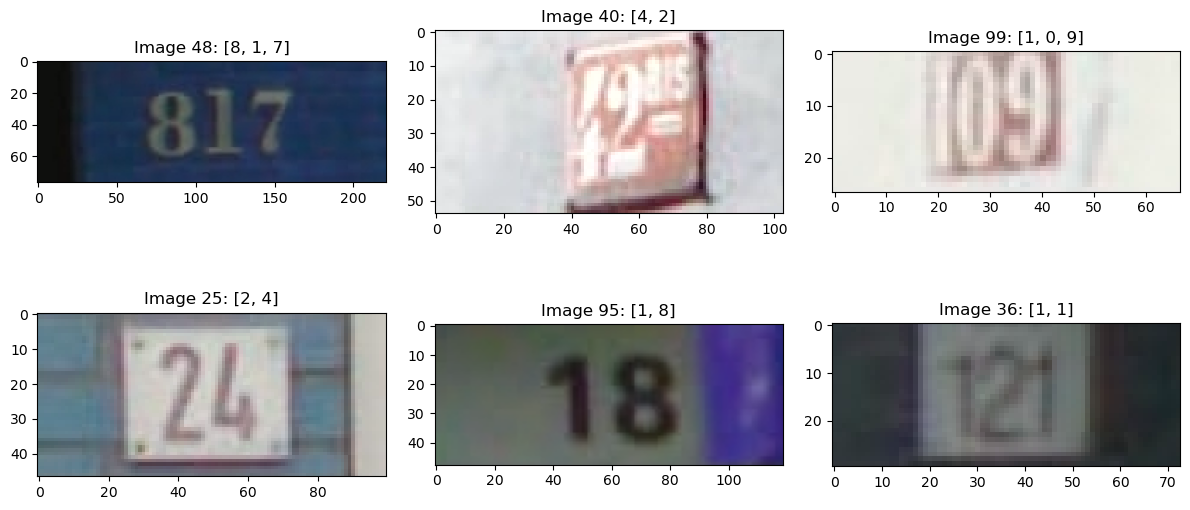

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])

In [3]:
"""Load dataset and preview
"""


def load_data(split: str = "train", path: Path = Path(), max_num: int = None) -> Dict[str, List]:
    dataset_dir = path/split
    label_file = dataset_dir/"digitStruct.mat"
    if not dataset_dir.exists():
        raise ValueError(f"The dataset path {dataset_dir} does not exist.")
    if not label_file.exists():
        raise ValueError(f"The label file {label_file} does not exist.")

    # Read labels
    with h5py.File(label_file, 'r') as h5_file:
        data_size = h5_file["digitStruct"]["name"].shape[0]
        if max_num:
            data_size = min(max_num, data_size)
        digits = [_get_digits(h5_file["digitStruct/bbox"][img_idx], h5_file)
                  for img_idx in range(data_size)]
        pass

    # Read imgs
    img_files = list(dataset_dir.glob("*.png"))
    img_files = sorted(img_files, key=lambda p: int(p.name.split(".")[0]))

    imgs = [cv2.imread(img_file.as_posix())
            for i, img_file in enumerate(img_files) if i < data_size]
    return {"labels": digits, "imgs": imgs}


def num_to_onehot(nums: np.ndarray) -> np.ndarray:
    """Convert a vector of int value into onehot representation.
    Value range from -1 to 9. The onehot representation has length of 12, where the last digit represents -1.
    E.g., for input nums = [3,-1], the output will be [[0,0,0,1,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,1]] 

    Args:
        nums (np.ndarray): Input int number vector, range from -1 to 9

    Returns:
        np.ndarray: Output onehot encoding.
    """
    nums[np.where(nums == -1)] = 11
    onehot = np.zeros([*nums.shape, 12], dtype=np.float64)
    x, y = np.where(np.ones_like(nums, dtype=np.bool_))
    onehot[x, y, nums.flatten()] = 1.0
    return onehot


def visualize_data(data):
    n = 6
    _, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()
    indices = np.argsort(np.random.rand(len(data["labels"])))[:n]
    for i, imgs_idx in enumerate(indices):
        # Use 'cmap' appropriate for your data
        axes[i].imshow(data["imgs"][imgs_idx])
        axes[i].set_title(f'Image {imgs_idx}: {data["labels"][imgs_idx]}')
    plt.tight_layout()
    plt.show()


data = load_data(split="train", path=Path("../data/Numbers"), max_num=100)
visualize_data(data)
nums = np.array([[2, 1, 0], [-1, 3, 9]])
num_to_onehot(nums)

### Make Dataset


In [4]:
"""Make dataset
"""
from torch.nn.functional import pad
digits_max_num = 6  # The max digits that can exist for one image


class SVHNDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir: Path = Path("../data/Numbers/"), split: str = "train", max_num: int = None, digits_max_num: int = 6):
        """This is the torch dataset for SVHN dataset.

        Args:
            dataset_dir (Path, optional): The path to dataset. Defaults to Path("./data/Numbers/").
            split (str, optional): The type of split. Should be one of ["train", "test"]. Defaults to "train".
            max_num (int, optional): Max number of data inside this dataset. 
                                     If the number is smaller than the total number of items existed, 
                                     this will be used to trunc the data. Defaults to None.
            digits_max_num (int, optional): Maximum number of digits that will contained inside each image. Defaults to 6.

        Raises:
            ValueError: Raise error if split is neither "test" nor "train".
        """
        self.digits_max_num = digits_max_num
        data = load_data(split=split, path=dataset_dir, max_num=max_num)
        self.labels, self.masks = self._read_labels(data)
        self.imgs = data["imgs"]
        self.split = split
        self.max_height = max(img.shape[1] for img in self.imgs)
        self.max_width = max(img.shape[2] for img in self.imgs)

        if self.split == "train":
            self.aug_seq = None
            '''Here you should implement your code that will use python lib iaa for creating a augmentation sequence self.aug_seq.
            The sequence will be used for augmenting input images before training.
            '''
            #########
            # Start #
            #########
            self.aug_seq = iaa.Sequential([
                # blur images with a sigma of 0 to 1.0
                iaa.GaussianBlur(sigma=(0, 1.0)),
                iaa.Affine(scale=(0.8, 1.2), rotate=(-25, 20)),
                iaa.Resize({"height": height, "width": width}),
                iaa.AddToHueAndSaturation((-20, 20))
            ])

            #######
            # End #
            #######
        elif self.split == "test":
            self.aug_seq = None
            #########
            # Start #
            #########
            self.aug_seq = iaa.Sequential([
                iaa.Resize({"height": height, "width": width})
            ])
            #######
            # End #
            #######
        else:
            raise ValueError(f"{split} is not in ['test', 'train'].")

    def _read_labels(self, data: Dict):
        padded_digits_onehot: np.ndarray = []
        masks: np.ndarray = []

        '''Here you should implement your code.
        You should read all digits from data and padding them so that they all contain the same number of values.
        Convert the padded matrix into onehot representation using the function padded_digits() defined before.
        Also create a mask for identify which part is unpadded and which part is padded for later loss and success rate calculation.
        Both should be a numpy array at the end. The dimension of the masks.shape == padded_digits_onehot.shape[:-1]
        '''
        for labels in data["labels"]:
            padded_digits_onehot.append(
                labels + [-1 for _ in range(self.digits_max_num + 2 - len(labels))])
            masks.append([True for _ in range(len(labels) + 1)] +
                         [False for _ in range(self.digits_max_num + 1 - len(labels))])

        padded_digits_onehot = np.array(padded_digits_onehot, dtype=np.int64)
        padded_digits_onehot = num_to_onehot(padded_digits_onehot)
        masks = np.array(masks, dtype=bool)
        return padded_digits_onehot, masks

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = self.aug_seq(image=img).transpose(2, 0, 1)/255.0
        label = self.labels[idx]
        mask = self.masks[idx]
        return img, label, mask


training_dataset = SVHNDataset(dataset_dir=Path(
    "../data/Numbers/"), split="train", max_num=3200)
test_dataset = SVHNDataset(dataset_dir=Path(
    "../data/Numbers/"), split="test", max_num=960)
img, label, mask = training_dataset[0]
img, label, mask

0.0005717277526855469
0.0005440711975097656
0.0004916191101074219
0.0005185604095458984
0.0004630088806152344
0.00045800209045410156
0.0004916191101074219
0.0006136894226074219
0.0007879734039306641
0.0004775524139404297
0.0006184577941894531
0.0005245208740234375
0.0005583763122558594
0.00047206878662109375
0.0004878044128417969
0.0005614757537841797
0.0005176067352294922
0.00046944618225097656
0.0006699562072753906
0.0004582405090332031
0.0001666545867919922
0.0006649494171142578
0.0004546642303466797
0.0005791187286376953
0.0006487369537353516
0.0005364418029785156
0.000667572021484375
0.00057220458984375
0.0006763935089111328
0.0004673004150390625
0.0006334781646728516
0.0004868507385253906
0.0004673004150390625
0.0004985332489013672
0.00021767616271972656
0.0004742145538330078
0.0004639625549316406
0.0004551410675048828
0.00047588348388671875
0.0005464553833007812
0.0004582405090332031
0.0006086826324462891
0.0005178451538085938
0.0007030963897705078
0.00044918060302734375
0.00062

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]),
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.

### Create Dataloader


In [5]:
train_dataloader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True)

### Dataloader Visualization


tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)

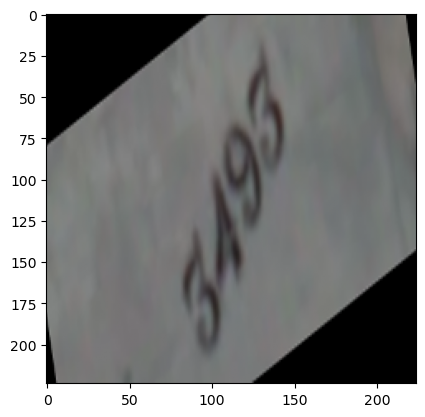

In [6]:
train_features, train_labels, train_masks = next(iter(train_dataloader))
plt.imshow(train_features[0].permute(1, 2, 0).cpu().numpy())
train_labels[0]

### Make model


In [7]:
"""Make model
"""


class CRNNModel(nn.Module):
    def __init__(self, input_size: int = 12, output_size: int = 12, max_sequence_length: int = 8,  hidden_dim: int = 512, n_layers: int = 1):
        super(CRNNModel, self).__init__()

        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        assert self.input_size == self.output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.max_sequence_length = max_sequence_length

        # Defining the layers
        # CNN Layer
        self.cnn = models.resnet18()
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, hidden_dim)

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x: torch.Tensor):
        B, C, H, W = x.shape

        h = self.cnn(x)  # B*HID
        h = h.reshape(self.n_layers, -1, self.hidden_dim)

        x = torch.zeros([B, 1, self.input_size],
                        device=x.device, dtype=x.dtype)
        x[:, :, -2] = 1.0  # Initial token, 10
        out = []
        for i in range(self.max_sequence_length):
            y, h = self.rnn(x, h)
            y = self.fc(y.squeeze())
            y = nn.functional.softmax(y, dim=-1)
            out.append(y)
            x = y[:, None, :]

        out = torch.stack(out, dim=0).permute(1, 0, 2)
        return out


model = CRNNModel().to(device=device, dtype=dtype)

### Train


In [8]:
"""Train
"""
n_epochs = 100
lr = 0.0001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
success_rates = []
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0
    batch_num = 0
    for batch in tqdm(train_dataloader):
        img, label, mask = batch
        optimizer.zero_grad()
        label = label.to(device=device, dtype=dtype)
        img = img.to(device=device, dtype=dtype)
        o = model(img)
        o[~mask] = label[~mask]
        loss = criterion(o, label)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batch_num += label.shape[0]
    if epoch % 1 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(epoch_loss/batch_num))

        # evaluate
        with torch.no_grad():
            evaluate_correct = 0
            evaluate_total = 0
            for batch in test_dataloader:
                img, label, mask = batch
                img = img.to(device=device, dtype=dtype)
                o = model(img)
                correct_mask = (torch.argmax(label, dim=-1) ==
                                torch.argmax(o, dim=-1)) & mask
                evaluate_correct += correct_mask.to(dtype=dtype).sum().item()
                evaluate_total += mask.to(dtype=dtype).sum().item()
            success_rate = evaluate_correct/evaluate_total
            print(f"success_rate: {success_rate}")
            success_rates.append(success_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

: 

### Visualization of test result


In [ ]:
img, label, mask = next(iter(test_dataloader))
label = label.to(device=device, dtype=dtype)
img = img.to(device=device, dtype=dtype)
o = model(img)
idx = 2
for idx in range(10):
    print(
        f"Prediction: {torch.argmax(o,dim=-1)[idx]}\nLabel: {torch.argmax(label,dim=-1)[idx]}")
    plt.imshow(label[idx].permute(1, 2, 0).cpu().numpy())
    plt.show()

### Plot Success Rate


In [ ]:
plt.plot(list(range(len(success_rates))), success_rates)

### Save Check Point


In [ ]:
torch.save(model, "./checkpoint")